# Jet Clustering

This workflow is for use with the jet samples, that contain both `ClusterTree` and `EventTree` (provided by the `MLTree` utility). This **cannot** handle data where the `EventTree` does not exist, because that contains info on piecing the clusters together into events*, and the baseline jet clustering.

\* This pieceing together can be accomplished in workflows like `EventReconstructionPion.ipynb` but it's rather complex.

### Setup

First, let's import a bunch of packages we know we'll need right off-the-bat.

Note that as we've set up our environment with `conda`, our `ROOT` installation has all the bells and whistles. This includes the `pythia8` library and its associated `ROOT` wrapper, `TPythia8`. We can optionally use this for jet-clustering, as it comes `fj-core`.
Alternatively we could use the Pythonic interface for `fastjet` or [pyjet](https://github.com/scikit-hep/pyjet), but the latter requires linking an external fastjet build for speed and this doesn't seem to work when following their documentation.

In [1]:
# Imports - generic stuff
import numpy as np
import ROOT as rt
import uproot as ur # uproot for accessing ROOT files quickly (and in a Pythonic way)
import sys, os, glob, uuid # glob for searching for files, uuid for random strings to name ROOT objects and avoid collisions
import subprocess as sub
from numba import jit
from pathlib import Path

path_prefix = '/workspace/LCStudies/'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import ml_util as mu # for passing calo images to regression networks
from util import qol_util as qu # for progress bar

Welcome to JupyROOT 6.22/02


In [2]:
# Imports and setup for TensorFlow and Keras.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

# Dictionary for storing all our neural network models that will be evaluated
network_models = {}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [3]:
# setup paths
data_dir = path_prefix + 'data/jet'
classification_dir = path_prefix + 'classifier/Models'
regression_dir = path_prefix + 'regression/Models'
fj_dir = path_prefix + '/setup/fastjet/fastjet-install/lib/python3.8/site-packages'

In [4]:
# ----- Calorimeter meta-data -----
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
nlayers = len(layers)
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
assert(len(len_phi) == nlayers)
assert(len(len_eta) == nlayers)
meta_data = {
    layers[i]:{
        'cell_size':(cell_size_eta[i],cell_size_phi[i]),
        'dimensions':(len_eta[i],len_phi[i])
    }
    for i in range(nlayers)
}

In [5]:
# flat classifiers
print('Loading flat classification models... ')
flat_model_files = glob.glob(classification_dir + '/flat/' + '*.h5')
flat_model_files.sort()
flat_model_names = []
for model in flat_model_files:
    model_name = model.split('model_')[-1].split('_flat')[0]
    print('\tLoading ' + model_name + '... ',end='')
    flat_model_names.append(model_name)
    network_models[model_name] = tf.keras.models.load_model(model)
    print('Done.')

# combo classifier
print('Loading simple combo classification model... ',end='')
combo_model_file = classification_dir + '/simple/' + 'model_simple_do20.h5'
network_models['combo'] = tf.keras.models.load_model(combo_model_file)
print('Done.')

# energy regression networks
print('Loading charged-pion energy regression model... ',end='')
charged_energy_model_file = regression_dir + '/' + 'all_charged.h5'
network_models['e_charged'] = tf.keras.models.load_model(charged_energy_model_file)
print('Done.')

print('Loading neutral-pion energy regression model... ',end='')
neutral_energy_model_file = regression_dir + '/' + 'all_neutral.h5'
network_models['e_neutral'] = tf.keras.models.load_model(neutral_energy_model_file)
print('Done.')

Loading flat classification models... 
	Loading EMB1... Done.
	Loading EMB2... Done.
	Loading EMB3... Done.
	Loading TileBar0... Done.
	Loading TileBar1... Done.
	Loading TileBar2... Done.
Loading simple combo classification model... Done.
Loading charged-pion energy regression model... Done.
Loading neutral-pion energy regression model... Done.


Now we make a "local" copy of the jet data. We will only copy over certain branches, and we will skip any files that don't contain an `eventTree` in them.

In [6]:
data_filenames = glob.glob(data_dir + '/' + '*.root')

# debugging - lets us use a single file to speed stuff up a lot.
#data_filenames = [data_dir + '/' + 'user.angerami.21685345.OutputStream._000062.root']

# our "local" data dir, where we create modified data files
jet_data_dir = path_prefix + 'jets/data'
Path(jet_data_dir).mkdir(parents=True, exist_ok=True)

# Get the original data.
files = {name:rt.TFile(name,'READ') for name in data_filenames}

# Some data files might be missing an EventTree.
# For now, we will skip these because our methods count on an existing EventTree.
delete_keys = []
for key, val in files.items():
    file_keys = [x.GetName() for x in val.GetListOfKeys()]
    if('ClusterTree' not in file_keys or 'EventTree' not in file_keys):
        delete_keys.append(key)

for key in delete_keys: 
    print('Ignoring file:',key,'(no EventTree/ClusterTree found).')
    del files[key]

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from  util import qol_util as qu # for progress bar

# now we make a local copy of the files in the jet_data_dir, keeping only certain branches
active_branches = {}
active_branches['cluster'] = [
    'runNumber',
    'eventNumber',
    'truthE',
    'truthPt',
    'truthEta',
    'truthPhi',
    'clusterIndex',
    'nCluster',
    'clusterE',
    'clusterECalib',
    'clusterPt',
    'clusterEta',
    'clusterPhi',
    'cluster_nCells',
    'cluster_ENG_CALIB_TOT',
    'EMB1',
    'EMB2',
    'EMB3',
    'TileBar0',
    'TileBar1',
    'TileBar2'
]
active_branches['event'] = [
    'runNumber',
    'eventNumber',
    'lumiBlock',
    'NPV',
    'nTruthPart',
    'clusterCount',
    'nCluster',
    'clusterE',
    'clusterPt',
    'clusterEta',
    'clusterPhi',
    'AntiKt4EMTopoJetsPt',
    'AntiKt4EMTopoJetsEta',
    'AntiKt4EMTopoJetsPhi',
    'AntiKt4EMTopoJetsE',
    'AntiKt4LCTopoJetsPt',
    'AntiKt4LCTopoJetsEta',
    'AntiKt4LCTopoJetsPhi',
    'AntiKt4LCTopoJetsE',
    'AntiKt4TruthJetsPt',
    'AntiKt4TruthJetsEta',
    'AntiKt4TruthJetsPhi',
    'AntiKt4TruthJetsE'
]

tree_names = {'cluster':'ClusterTree','event':'EventTree'}
data_filenames = []

l = len(files.keys())
i = 0
qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)

for path, tfile in files.items():
    filename_new = jet_data_dir + '/' + path.split('/')[-1]
    old_trees = {x:tfile.Get(tree_names[x]) for x in tree_names.keys()}
    
    for key, tree in old_trees.items():
        tree.SetBranchStatus('*',0)
        for bname in active_branches[key]: tree.SetBranchStatus(bname,1)
    
    tfile_new = rt.TFile(filename_new,'RECREATE')
    new_trees = {x:old_trees[x].CloneTree() for x in old_trees.keys()}
    tfile_new.Write()
    data_filenames.append(filename_new)
    i += 1
    qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)
    del old_trees
    del new_trees

Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000729.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000225.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000259.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000272.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000270.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000077.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000308.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000026.root (no EventT

In [7]:
# Access the files & trees with uproot
tree_names = {'cluster':'ClusterTree','event':'EventTree'}
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

### Getting network outputs for all clusters

Now we will loop over our data files. This isn't the most notebook-esque code, but it should avoid "out of memory" issues: As we are dealing with a large amount of data, preparing all the data in memory before operating on it will result in very high memory usage. Thus we will sacrifice a multi-cell approach of preparing all the data step-by-step, in order to make sure we don't load more stuff into memory at a time than we need.

In [8]:
# branch buffer for filling our score trees
    # make our branch buffer
branch_buffer = {
    'charged_likelihood_combo': np.zeros(1,dtype=np.dtype('f8')),
    'clusterE_charged': np.zeros(1,dtype=np.dtype('f8')),
    'clusterE_neutral': np.zeros(1,dtype=np.dtype('f8'))
}

for dfile, trees in ur_trees.items():
    
    print (dfile)
    # prep the calo images
    print('\tPrepping calo images...')
    calo_images = {}
    for layer in layers:
        calo_images[layer] = mu.setupCells(trees['cluster'],layer)
    combined_images = np.concatenate(tuple([calo_images[layer] for layer in layers]), axis=1)

    # prep some extra combined input for energy regression
    print('\tPrepping extra inputs...')
    scaler_e = StandardScaler()
    scaler_cal = StandardScaler()
    scaler_eta = StandardScaler()
    
    e = trees['cluster'].array('clusterE')
    e_calib = trees['cluster'].array('cluster_ENG_CALIB_TOT')
    eta = trees['cluster'].array('clusterEta')
    
    # cleaning for e and e_calib (empirically needed for e_calib to remove values that are too large)
    epsilon = 1.0e-12
    e = np.where(e < epsilon, epsilon, e)
    e_calib = np.where(e_calib < epsilon, epsilon, e_calib)
    
    regression_cols = {}
    regression_cols['s_logE'] = scaler_e.fit_transform(np.log(e).reshape(-1,1))
    regression_cols['s_logECalib'] = scaler_cal.fit_transform(np.log(e_calib).reshape(-1,1))
    regression_cols['s_eta'] = scaler_eta.fit_transform(eta.reshape(-1,1))
    
    s_combined,scaler_combined = mu.standardCells(combined_images, layers)
    regression_input = np.column_stack((regression_cols['s_logE'], regression_cols['s_eta'],s_combined))

    # now find network scores
    print('\tCalculating network outputs...')
    model_scores = {}
    
    print('\t\tClassification... ', end='')
    # 1) flat networks
    for layer in flat_model_names:
        model = network_models[layer]
        model_scores[layer] = model.predict(calo_images[layer])[:,1] # [:,1] based on Max's code, this is input to combo network. Likelihood of being charged (vs. neutral)
    
    # 2) combo network
    name = 'combo'
    model = network_models[name]
    input_scores = np.column_stack([model_scores[layer] for layer in layers])
    model_scores[name] = model.predict(input_scores)[:,1] # likelihood of being charged pion (versus neutral pion)
    print('Done.')
    
    print('\t\tRegression... ', end='')
    # 3) energy regression networks
    name = 'e_charged'
    model = network_models[name]
    model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))
    
    name = 'e_neutral'
    model = network_models[name]
    model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))
    print('Done.')
    
    # Now we should save these scores to a new tree.
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'ScoreTree'
    t = rt.TTree(tree_name, tree_name)
    
    print('Saving network scores to tree ' + tree_name + '... ',end='')    
    # --- Setup the branches using our buffer. This is a rather general/flexible code block. ---
    branches = {}
    for bname, val in branch_buffer.items():
        descriptor = bname
        bshape = val.shape
        if(bshape != (1,)):
            for i in range(len(bshape)):
                descriptor += '[' + str(bshape[i]) + ']'
        descriptor += '/'
        if(val.dtype == np.dtype('i2')): descriptor += 'S'
        elif(val.dtype == np.dtype('i4')): descriptor += 'I'
        elif(val.dtype == np.dtype('i8')): descriptor += 'L'
        elif(val.dtype == np.dtype('f4')): descriptor += 'F'
        elif(val.dtype == np.dtype('f8')): descriptor += 'D'
        else:
            print('Warning, setup issue for branch: ', key, '. Skipping.')
            continue
        branches[bname] = t.Branch(bname,val,descriptor)
    
    # Fill the model score tree, and save it to the local data file.
    nentries = model_scores['combo'].shape[0]
    for i in range(nentries):
        branch_buffer['charged_likelihood_combo'][0] = model_scores['combo'][i]
        branch_buffer['clusterE_charged'][0] = model_scores['e_charged'][i]
        branch_buffer['clusterE_neutral'][0] = model_scores['e_neutral'][i]
        t.Fill()
    
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()
    print('Done.')
    
tree_names['score'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000897.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000724.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000801.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000767.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000062.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000113.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000762.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.


Before moving on to jet clustering, we can already check to see if our energy regressions seem sensible. Let's make distributions of:
- The classification score
- Each regressed energy, for **all** clusters (i.e. charged and neutral energy regressions for all clusters regardless of their classifications)
- Regressed energy / reco energy, where we choose the regressed energy for each cluster based on its classification score

Number of clusters with ENG_CALIB_TOT == 0: 8.53e+05 (36.75% of clusters)


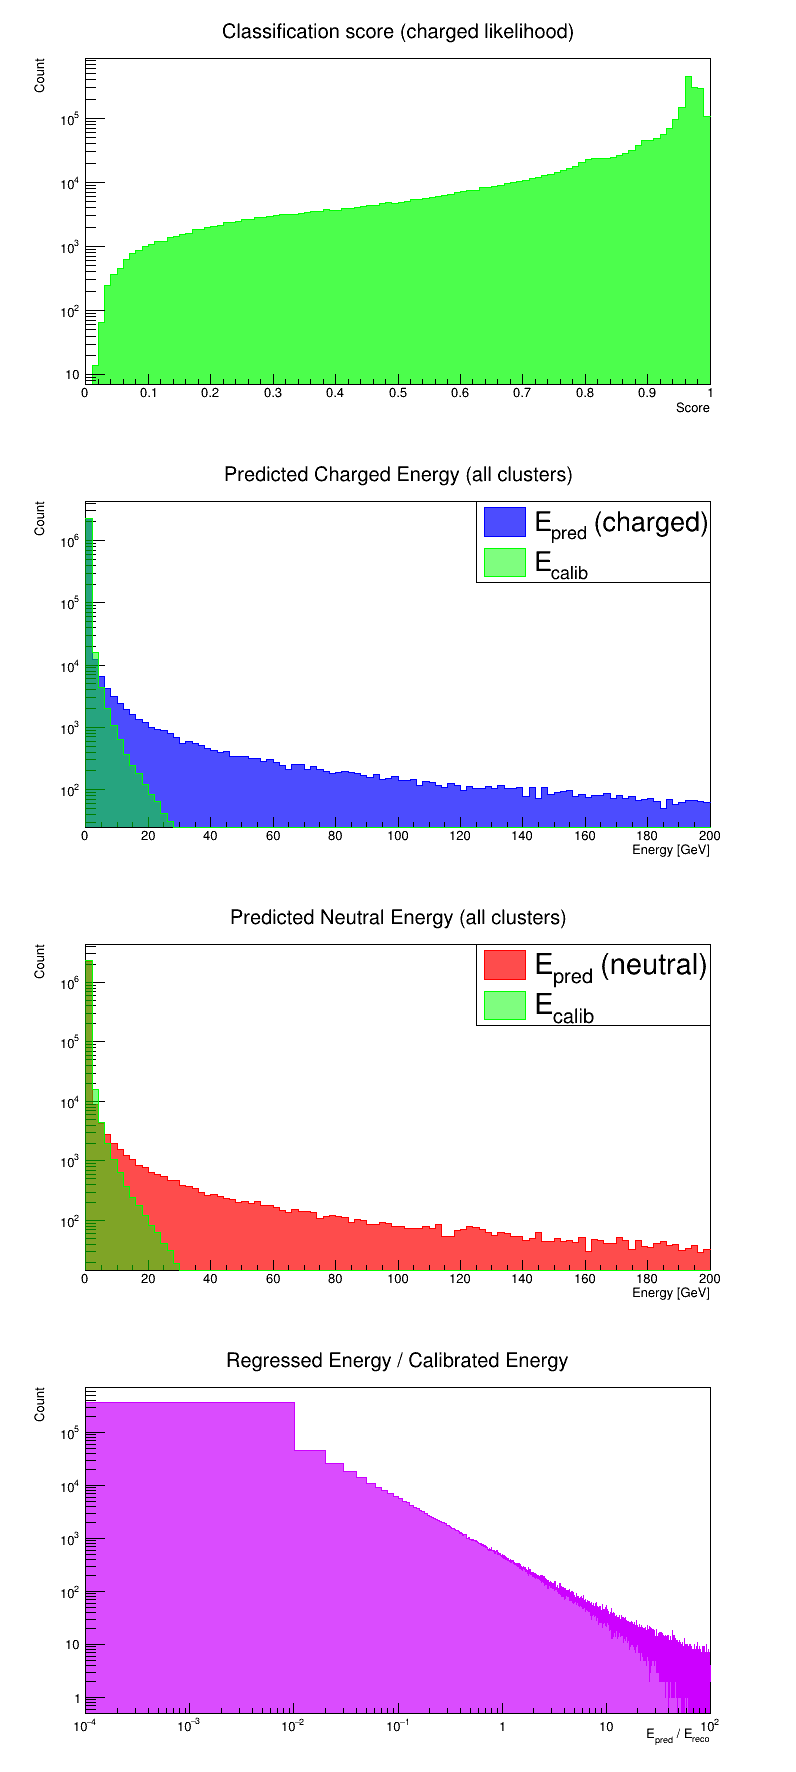

In [9]:
c = rt.TCanvas(str(uuid.uuid4()),'network checks',800,1800)
c.Divide(1,4)

# classification scores
class_hist = rt.TH1F(str(uuid.uuid4()), 'Classification score (charged likelihood);Score;Count',100,0.,1.)
for dfile, trees in ur_trees.items():
    for score in ur_trees[dfile]['score'].array('charged_likelihood_combo'): class_hist.Fill(score)
class_hist.SetFillColorAlpha(rt.kGreen,0.7)
class_hist.SetLineColor(rt.kGreen)
c.cd(1)
class_hist.Draw('HIST')
rt.gPad.SetLogy()

# energy regressions - for all clusters (score-agnostic)

true_e_hist = rt.TH1F(str(uuid.uuid4()), 'Calibrated Energy (all clusters);Energy [GeV];Count',100,0.,200.)
for dfile, trees in ur_trees.items():
    for energy in ur_trees[dfile]['cluster'].array('cluster_ENG_CALIB_TOT'): true_e_hist.Fill(energy)

charged_hist = rt.TH1F(str(uuid.uuid4()), 'Predicted Charged Energy (all clusters);Energy [GeV];Count',100,0.,200.)
for dfile, trees in ur_trees.items():
    for energy in ur_trees[dfile]['score'].array('clusterE_charged'): charged_hist.Fill(energy)

neutral_hist = rt.TH1F(str(uuid.uuid4()), 'Predicted Neutral Energy (all clusters);Energy [GeV];Count',100,0.,200.)
for dfile, trees in ur_trees.items():
    for energy in ur_trees[dfile]['score'].array('clusterE_neutral'): neutral_hist.Fill(energy)

true_e_hist.SetFillColorAlpha(rt.kGreen,0.5)
true_e_hist.SetLineColor(rt.kGreen)  

charged_hist.SetFillColorAlpha(rt.kBlue,0.7)
charged_hist.SetLineColor(rt.kBlue)  

neutral_hist.SetFillColorAlpha(rt.kRed,0.7)
neutral_hist.SetLineColor(rt.kRed) 

c.cd(2)
leg1 = rt.TLegend(0.6,0.7,0.9,0.9)
leg1.AddEntry(charged_hist,'E_{pred} (charged)','f')
leg1.AddEntry(true_e_hist,'E_{calib}','f')

charged_hist.Draw('HIST')
true_e_hist.Draw('HIST SAME')
leg1.Draw()
rt.gPad.SetLogy()

c.cd(3)
leg2 = rt.TLegend(0.6,0.7,0.9,0.9)
leg2.AddEntry(neutral_hist,'E_{pred} (neutral)','f')
leg2.AddEntry(true_e_hist,'E_{calib}','f')

neutral_hist.Draw('HIST')
true_e_hist.Draw('HIST SAME')
leg2.Draw()
rt.gPad.SetLogy()

# regressed energy (most likely) / reco energy
zero_energies = 0
n_tot = 0
classification_threshold = 0.5
energy_ratio_hist = rt.TH1F(str(uuid.uuid4()), 'Regressed Energy / Calibrated Energy;E_{pred} / E_{reco};Count',10000,1.0e-4,1.0e2)
for dfile, trees in ur_trees.items():
    scores = trees['score'].array('charged_likelihood_combo')
    charged_e = trees['score'].array('clusterE_charged')
    neutral_e = trees['score'].array('clusterE_neutral')
    true_e = trees['cluster'].array('cluster_ENG_CALIB_TOT')
    n_tot += len(true_e)
    
    for i in range(len(scores)):
        if(true_e[i] == 0.):
            zero_energies += 1
            continue
        if(scores[i] > 0.5): energy_ratio_hist.Fill(charged_e[i] / true_e[i])
        else: energy_ratio_hist.Fill(neutral_e[i] / true_e[i])

energy_ratio_hist.SetFillColorAlpha(rt.kViolet,0.7)
energy_ratio_hist.SetLineColor(rt.kViolet)
c.cd(4)
energy_ratio_hist.Draw('HIST')
rt.gPad.SetLogx()
rt.gPad.SetLogy()
energy_ratio_hist.GetXaxis().SetRangeUser(1.0e-4, 1.0e2)

rt.gStyle.SetOptStat(0)

print('Number of clusters with ENG_CALIB_TOT == 0: {val1:.2e} ({val2:.2f}% of clusters)'.format(val1 = zero_energies, val2 = 100. * zero_energies / n_tot))

c.Draw()

While we will continue with the workflow, we can already see that something is off. 

While these plots might not tell the *full* story -- maybe there's a better choice for classification threshold -- we see *lots* of predicted energies that are way larger than any reconstruction-level energies we encounter. In other words, the fact that we have lots of high entries in both the the $\color{blue}2^\text{nd}$ and $\color{red}3^\text{rd}$ histograms is a little strange, and the $\color{purple}4^\text{th}$ confirms that something is really off as we have a *lot* of entries very far below $1$, as well as quite a few much larger than $1$ (note that this is a log-log plot!).

### Jet clustering

Now, we want to perform jet-clustering, where we'll use the regressed energies (and the classification score will tell us which regressed energy to use for each cluster).

First, let's set up some information on cuts we want to make. 
- We will have a *global* jet $eta$ cut, so that we only consider jets within a certain $eta$ window. We do this as we only have topo-cluster images for topo-clusters with $|\eta| < 0.7$, so we will see some edge effects if performing clustering near that boundary.
- We will apply a *minimum energy cut* on our truth jets. When performing jet matching, we will only be matching reco jets to truth jets that pass this cut.

In [10]:
global_eta_cut = 0.3 # eta cut to be applied to all jets -- those we make and those we're given
global_truth_e_cut = 25. # GeV -- recall that jet energies are stored in keV!

# pavetext with info on cuts
cut_info = [
    '|#eta_{j}| <' + ' {val:.1f},'.format(val=global_eta_cut),
    'E_{j}^{true}' + ' > {val:.0f} [GeV],'.format(val=global_truth_e_cut),
    'All reco jets matched',
    'to truth w/ #Delta R < 0.3 .'
]

cut_pave = rt.TPaveText(0.7, 0.5, 0.9, 0.7, 'NDC')
cut_pave.SetFillColor(0)
cut_pave.SetBorderSize(0)
cut_pave.SetTextFont(42)
cut_pave.SetTextSize(0.03)
cut_pave.SetTextAlign(12)
for line in cut_info: 
    cut_pave.AddText(line)

Now let's perform our jet clustering employing our regressed topo-cluster energies, and save these new jets as `AntiKt4MLTopoJets` in a new tree in each of our files, `JetTree`.

In [11]:
# import fastjet!
sys.path.append(fj_dir)
import fastjet as fj

# Jet clustering params
R = 0.4
pt_min = 0.0 # min jet pT (GeV) to be applied to jets we cluster (appears to be a 5.0 GeV cut on truth jets & existing reco jets)
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)
eta_max = global_eta_cut # our eta cut, that we will apply to all jets

#energy rescaling (all jet info is saved in MeV, cluster info is in GeV -> must rescale)
energy_scaling = 1.0e3

# classification threshold - scores below are considered neutral pion clusters, scores above are considered charged pion clusters
classification_threshold = 0.5

# branch buffer for our jet tree
branch_buffer = {
    'AntiKt4MLTopoJetsPt':rt.std.vector('float')(),
    'AntiKt4MLTopoJetsEta':rt.std.vector('float')(),
    'AntiKt4MLTopoJetsPhi':rt.std.vector('float')(),
    'AntiKt4MLTopoJetsE':rt.std.vector('float')()
}

for dfile, trees in ur_trees.items():
    
    # event info
    cluster_min = trees['event'].array('clusterCount') # naming convention is a bit funny! clusterCount gives event starting index in ClusterTree
    cluster_max = cluster_min + trees['event'].array('nCluster') - 1
    
    # cluster info (pre-existing) #TODO; we include reco cluster E info for debugging purposes only
    cluster_vec = np.column_stack(tuple(trees['cluster'].arrays(['clusterPt','clusterEta','clusterPhi','clusterE']).values()))
    
    # topo-cluster classifications for all of the clusters in this file
    cluster_classification = trees['score'].array('charged_likelihood_combo')
    
    # topo-cluster regressed energies for all clusters in this file (regressions assuming cluster comes from charged/neutral pion)
    cluster_energies = np.column_stack(tuple(trees['score'].arrays(['clusterE_charged','clusterE_neutral']).values()))
    
    # tree for saving jet info
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'JetTree'
    t = rt.TTree(tree_name, tree_name)
    branches = {}
    for key,val in branch_buffer.items():
        branches[key] = t.Branch(key, val)
    
    vec_polar = rt.Math.PtEtaPhiEVector()    
    # loop over events
    nevents = trees['event'].numentries
    for i in range(nevents):
        
        # explicit list of cluster indices we're working with -- these are indices in ClusterTree, corresponding to event i
        cluster_idxs = np.linspace(cluster_min[i], cluster_max[i], cluster_max[i] - cluster_min[i] + 1, dtype=np.dtype('i8'))        
        # nCluster = cluster_idxs.shape[0]
                
        pseudojets = []
        for idx in cluster_idxs:
            energy = cluster_energies[idx,0] # swap in the regressed energy, start off assuming a charged pion
            if cluster_classification[idx] < classification_threshold: energy = cluster_energies[idx,1] # switch to neutral energy regression if dictated by classification
            
            # get the ratio of the regressed energy to the original reco energy
            energy_ratio = energy / cluster_vec[idx,3]
            
            # rescale the pT according to how we've changed the topo-cluster energy (don't touch eta, phi)
            pt = cluster_vec[idx,0] * energy_ratio
            
            # create 4-vector representing the topo-cluster
            vec_polar.SetCoordinates(pt,cluster_vec[idx,1],cluster_vec[idx,2],energy)
            
            # make a fastjet PseudoJet object from this 4-vector, add it to the list that will be given to jet clustering
            pseudojets.append(fj.PseudoJet(vec_polar.Px(), vec_polar.Py(), vec_polar.Pz(), vec_polar.E())) # fastjet uses Cartesian as input
        
        # perform jet clustering
        jets = jet_def(pseudojets)
        
        # Apply optional minimum jet pT cut
        jet_pt = np.array([jet.pt() for jet in jets])
        jet_indices = np.linspace(0,len(jets)-1,len(jets),dtype=np.dtype('i8'))[jet_pt >= pt_min]
        jets = [jets[i] for i in jet_indices]
        
        # Apply optional maximum |eta| cut
        jet_eta = np.array([jet.eta() for jet in jets])
        jet_indices = np.linspace(0,len(jets)-1,len(jets),dtype=np.dtype('i8'))[np.abs(jet_eta) <= eta_max]
        jets = [jets[i] for i in jet_indices]
        
        # Save jet info to a TTree
        njets = len(jets)
        for key in branch_buffer.keys(): branch_buffer[key].clear() 
        for j in range(njets):    
            branch_buffer['AntiKt4MLTopoJetsPt'].push_back(jets[j].pt() * energy_scaling)
            branch_buffer['AntiKt4MLTopoJetsEta'].push_back(jets[j].eta())
            branch_buffer['AntiKt4MLTopoJetsPhi'].push_back(jets[j].phi())
            branch_buffer['AntiKt4MLTopoJetsE'].push_back(jets[j].e() * energy_scaling)
        
        t.Fill()
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()

# update our uproot tree access dictionary, adding our new tree!
tree_names['jet'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


### Jet matching

Now, we want to match the jets we just clustered with the truth jets, to see how well we've reconstructed things.

Here's how we will perform jet-matching:

- Get the list of all reco jets and truth jets for an event
- Loop through the truth jets
    - Find the closest reco jet within $\Delta R=0.3$, if it exists, and call it a match
        - If we fail to find a match, make a note of this
    - Take the matched reco jet off the list, so we don't match it a 2nd time
    
From matched jets, we will immediately compute $E_\text{reco}/E_\text{true}$ and histogram it (we will *not* be saving the matches directly to a file, for now).

We will perform this process for all the different reco jet definitions in the files, so that we can compare our method's energy resolution to the others'.

In [12]:
# Returns pairs & lists of matched and unmatched indices. These indices are w.r.t.
# whatever is given as input -- if some jets have been dropped from lists (for not passing cuts)
# this will *not* be known to jet_matching(). (i.e. it will always work 
# internally with a set of sequential indices, with which it reports results.)

#TODO: Try to speed up using numba within.

def jet_matching(reco_jets, truth_jets, max_distance = 0.3):
    ntruth = len(truth_jets['eta'])
    nreco = len(reco_jets['eta'])
    reco_indices = np.linspace(0, nreco, nreco + 1, dtype = np.dtype('i2'))
    
    #TLorentzVectors for computing deltaR
    vec1 = rt.Math.PtEtaPhiEVector()
    vec2 = rt.Math.PtEtaPhiEVector()

    matched_indices = []
    unmatched_truth = []
    unmatched_reco = []
    
    for i in range(ntruth):
        truth_eta = truth_jets['eta'][i]
        truth_phi = truth_jets['phi'][i]
        vec1.SetCoordinates(0.,truth_eta,truth_phi,0.)
        
        # get distances between this truth jet and all unmatched reco jets
        distances = np.zeros(nreco)
        for j in range(nreco):
            reco_idx = reco_indices[j]
            if(reco_idx < 0):
                distances[j] = -999.
                continue 
            vec2.SetCoordinates(0.,reco_jets['eta'][reco_idx],reco_jets['phi'][reco_idx],0.)
            distances[j] = rt.Math.VectorUtil.DeltaR(vec1,vec2)
            
        # now find the minimum distance, beware of negative values
        # see https://stackoverflow.com/a/37973409
        valid_idx = np.where(distances >= 0.)[0]
        
        if(len(valid_idx) == 0):
            unmatched_truth.append(i)
            continue
        
        match_idx = valid_idx[distances[valid_idx].argmin()]
        matched_indices.append((i, match_idx))
        reco_indices[match_idx] = -1.
    unmatched_reco = reco_indices[reco_indices > -1]
    
    return {'truth_reco':matched_indices, 'unmatched_truth':unmatched_truth, 'unmatched_reco':unmatched_reco}

Let's save the reco jet matching information to a new tree. A few notes on this information:

-  For each reconstruction-level jet type (EM, LC, ML), we will save a vector of ints for each event. The vector is of the same length as the number of reco jets in that event, and each position will give the index of the truth jet to which that reco jet is matched. Unmatched reco jets will be represented in this vector with a $-1$.
- Any cuts applied to reco jets should be built-in here. If a reco jet fails to pass a reco jet cut, we won't even bother trying to match it (and will label it as unmatched).
- Any cuts on the truth jets should also be built-in here. For example, if we're only considering truth jets with energy > 25 GeV, we are only interested in reco jets that are matched to truth jets that pass this cut. So, we will use that cut when applying the matching, versus just matching any and all jets and worrying about this cut later on. This should make plotting kinematics easier later on, with the caveat that we cannot look at reco jets matched to truth jets that *do not* pass our truth jet cuts, without redoing this step with those cuts removed.

In [13]:
# Convenience function -- see workflow below. This converts from
# indices with respect to a list of selected jets, to indices
# with respect to all indices in the original tree (passed as inputs).
@jit
def IndexConversion(index_matrix, reco_indices, truth_indices):
    index_matrix[:,0] = truth_indices[index_matrix[:,0]]
    index_matrix[:,1] = reco_indices[index_matrix[:,1]]
    return index_matrix
    
#Saving jet matching info to a new tree

R = 0.3 # radius for jet-matching

index_type = ('int',np.dtype('i4')) # allows us to choose how we store matching indices, e.g. int, short
branch_buffer = {
    'AntiKt4EMTopoJetsMatch':rt.std.vector(index_type[0])(),
    'AntiKt4LCTopoJetsMatch':rt.std.vector(index_type[0])(),
    'AntiKt4MLTopoJetsMatch':rt.std.vector(index_type[0])()
}
jet_definitions = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets'),
    'Truth':('event', 'AntiKt4TruthJets')
}
reco_jet_defs = ['EM','LC','ML']

for dfile, tree in ur_trees.items():   
        
    # tree for saving jet matching info
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'JetMatchTree'
    t = rt.TTree(tree_name, tree_name)
    branches = {}
    for key,val in branch_buffer.items():
        branches[key] = t.Branch(key, val)
    
    # Determine which jets pass our global eta cut.
    eta = {key:tree[val[0]].array(val[1] + 'Eta') for key, val in jet_definitions.items()}
    jet_indices = {key: np.abs(x) <= global_eta_cut for key,x in eta.items()}
    
    # Apply our truth jet energy cut. Recall that jets have things stored in MeV for now, whereas the cut is in GeV.
    truth_energy = tree[jet_definitions['Truth'][0]].array(jet_definitions['Truth'][1] + 'E')
    jet_indices['Truth'] = jet_indices['Truth'] * (truth_energy >= 1.0e3 * global_truth_e_cut)
    
    # We will also need phi info for performing the matching.
    phi = {key:tree[val[0]].array(val[1] + 'Phi') for key, val in jet_definitions.items()}

    nevents = ur_trees[dfile]['event'].numentries
    for i in range(nevents):
        
        # For each event, store the jets that have passed our pre-selection cuts.
        selected_jets = {}
        
        for key in jet_indices.keys():
            selected_jets[key] = {'eta':eta[key][i][jet_indices[key][i]],'phi':phi[key][i][jet_indices[key][i]]}
            
        # TODO: Consider eliminating this conditional, see if it really speeds things up at all.
        # Speedup: Skip to next event if *no* truth jets were selected (there will be no matching to do anyway).
        # Make sure to fill our branch buffers with -1 for each reco jet, to explicitly label them as unmatched.
        # (We want the length of these vectors to *always* match the number of reco jets!)
        if(len(selected_jets['Truth']['eta']) == 0): 
            for rdef in reco_jet_defs:
                buffer_key = jet_definitions[rdef][1] + 'Match'
                branch_buffer[buffer_key].clear()
                n = len(jet_indices[rdef][i]) # total number of reco jets for this event (including those not passing cuts)
                for j in range(n): branch_buffer[buffer_key].push_back(int(-1))
            t.Fill()
            continue
            
        # Keeping track of which indices are present and dropped.
        # For each jet definition, this dictionary lists all jet indices w.r.t. the tree, that have passed cuts.
        # E.g. if EM jets at positions 0, 4 and 5 in our branch passed cuts, then jet_tree_indices['EM']=np.array([0,4,5]).
        # More user-friendly than a boolean array of full length, e.g. [True, False, False, False, True, True,...].
        # Note that jet_indices[key] is an Awkward array, so jet_indices[key][i] gives the i'th entry, for the i'th event,
        # whose length might differ from the j'th entry jet_indices[key][j] (a.k.a. a "jagged array").
        jet_tree_indices = {key:np.linspace(0,len(jet_indices[key][i])-1,len(jet_indices[key][i]),dtype=np.dtype('i2'))[jet_indices[key][i]] for key in jet_indices.keys()}        
        
        # Now perform matching for each reco jet definition.
        for rdef in reco_jet_defs:
            buffer_key = jet_definitions[rdef][1] + 'Match' # key for accessing TTree branch buffer
            branch_buffer[buffer_key].clear()

            # Info on (reco,truth) pairs, as well as any unmatched reco and truth jets.
            matches, unmatch_true, unmatch_reco = jet_matching(reco_jets=selected_jets[rdef], truth_jets=selected_jets['Truth'], max_distance=R).values()
            
            # If we don't find matches, we can skip the rest of this loop. 
            # Make sure to fill the vectors with a bunch of -1's to indicate unmatched reco jets.
            # (We want the length of these vectors to *always* match the number of reco jets!)
            if(matches == []):
                n = len(jet_indices[rdef][i])
                for j in range(n): branch_buffer[buffer_key].push_back(int(-1))
                continue
                
            # Convert from indices amongst selected jets, to indices amongst all jets in tree.
            matches = IndexConversion(np.array(matches,dtype=index_type[1]), jet_tree_indices[rdef], jet_tree_indices['Truth'])           
     
            # Now prepare to fill the branch buffer. Each position correspond to a reco jet in our tree.
            # We will fill each position with the index of the truth jet (in the tree) to which it's matched.
            # If a particular reco jet is not matched, we will label it with a -1.
        
            # We prep results in a numpy array, we'll push_back the whole thing when ready.
            match_list = np.full(len(jet_indices[rdef][i]),-1,dtype=index_type[1])
            for row in matches: match_list[row[1]] = row[0]            
            
            # Now prepare to fill the branch buffer. Each position correspond to a reco jet in our tree.
            # We will fill each position with the index of the truth jet (in the tree) to which it's matched.
            # If a particular reco jet is not matched, we will label it with a -1.
            
            # Note that the first column of matches gives truth jet indices, the second column gives reco indices.
            # We will first fill the vector with -1's, then make replacements as necessary (we can treat it like np vector).
            for entry in match_list: branch_buffer[buffer_key].push_back(int(entry)) # TODO: Why do we need to cast to Python int?
            
        # The branch buffers have been filled, time to write this event to the tree.
        t.Fill()
    
    # Done writing events. Write tree to file
    t.Write(tree_name,rt.TObject.kOverwrite)
    f.Close()
    
# update our uproot tree access dictionary, adding our new tree!
tree_names['jet_match'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

**TODO:** Use our matching info to plot energy ratios & make selections for all jet kinematic plots.

In [14]:
def SetColor(hist, color, alpha = 0.5):
    hist.SetLineColor(color)
    hist.SetFillColorAlpha(color, alpha)

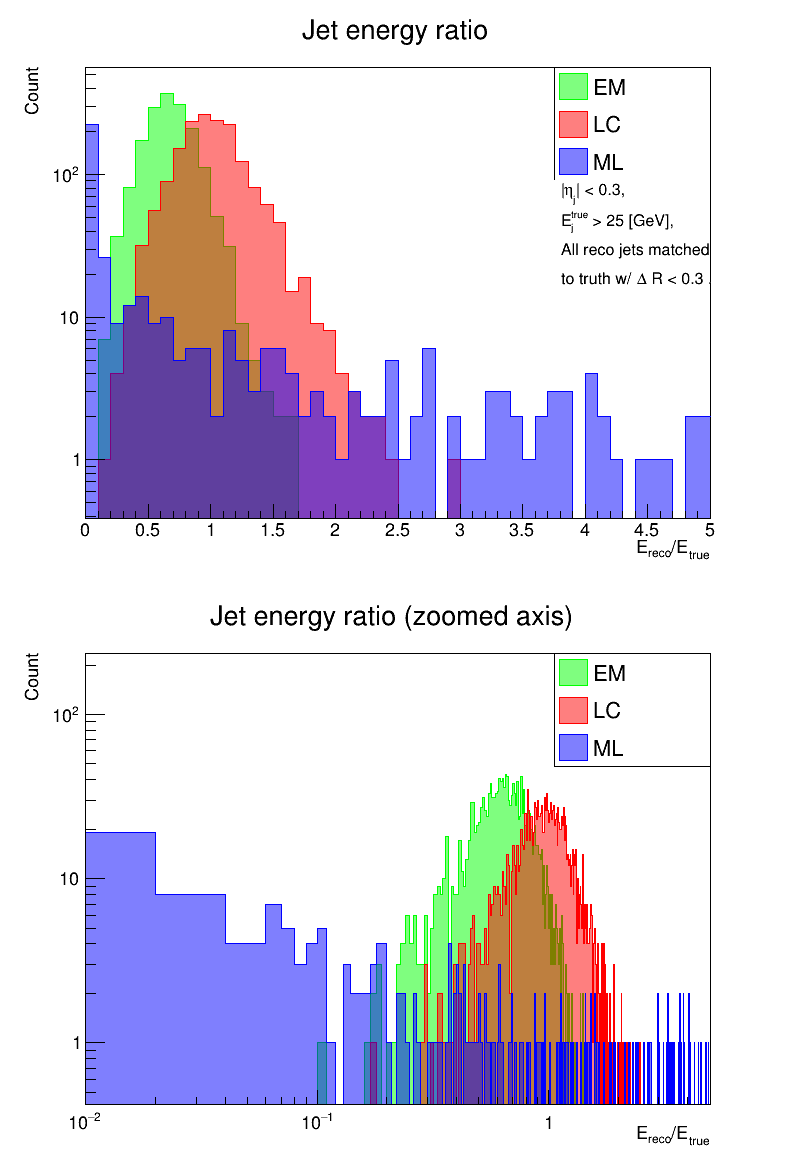

In [15]:
# redefining from above to be explicit
reco_jet_definitions = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets')
}
truth_jet_definition = 'AntiKt4TruthJets'

# histograms to fill
colors = {
    'EM':rt.kGreen,
    'LC':rt.kRed,
    'ML':rt.kBlue
}

min_ratio = 0.
max_ratio = 5.
nbins = 50

hists = {key: rt.TH1F(str(uuid.uuid4()), key + ';E_{reco}/E_{true};Count',nbins,min_ratio,max_ratio) for key in reco_jet_definitions.keys()}
hists_zoomed = {key: rt.TH1F(str(uuid.uuid4()), key + ' (zoomed axis);E_{reco}/E_{true};Count',10 * nbins,min_ratio,max_ratio) for key in reco_jet_definitions.keys()}

for key in colors.keys():
    SetColor(hists[key],colors[key])
    SetColor(hists_zoomed[key],colors[key])

# now loop through our files and fill the trees
for dfile, tree in ur_trees.items():
    truth_energy = tree['event'].array(truth_jet_definition + 'E')
    
    # make a histogram for each reco jet definition
    for key, rdef in reco_jet_definitions.items():
        reco_energy = tree[rdef[0]].array(rdef[1] + 'E')
        reco_match  = tree['jet_match'].array(rdef[1] + 'Match')
        
        # looping through events in this file (these are jagged arrays)
        for i in range(len(reco_match)):
            # looping through truth jets, plot match for each one that has a match
            for j in range(len(reco_match[i])):
                if(reco_match[i][j] > -1): 
                    hists[key].Fill(reco_energy[i][j] / truth_energy[i][reco_match[i][j]])
                    hists_zoomed[key].Fill(reco_energy[i][j] / truth_energy[i][reco_match[i][j]])

# draw the histograms we just made
c = rt.TCanvas(str(uuid.uuid4()),'c_energy_ratio',800, 1200)
rt.gStyle.SetOptStat(0)

legend = rt.TLegend(0.7,0.7,0.9,0.9)
for key in hists.keys(): legend.AddEntry(hists[key],key,'f')

c.Divide(1,2)
c.cd(1)
stack1 = rt.THStack(str(uuid.uuid4()),'s1')
stack1.SetTitle('Jet energy ratio;E_{reco}/E_{true};Count')
for hist in hists.values(): stack1.Add(hist)
stack1.Draw('NOSTACK HIST')
rt.gPad.SetLogy()
legend.Draw()
cut_pave.Draw()

c.cd(2)
stack2 = rt.THStack(str(uuid.uuid4()),'s1')
stack2.SetTitle('Jet energy ratio (zoomed axis);E_{reco}/E_{true};Count')
for hist in hists_zoomed.values(): stack2.Add(hist)
stack2.Draw('NOSTACK HIST')
rt.gPad.SetLogx()
rt.gPad.SetLogy()
legend.Draw()

c.Draw()

Some of the stuff we're seeing above looks weird. Many of the cluster energies are too low, but there's also a very large tail to the distribution.

Note that there seems to have been an issue with **units** that I have already accounted for: Based on the magnitude of their values, I think that the truth jets and existing reco jets (EM, LC) had their $p_T$ and energy values stored in keV, not GeV. I have adjusted the ML jets to store their info in keV too to match, and we will convert to GeV for all for plotting.

But even with this rescaling having been done, we see issues such as in the plot above.

## Jet Kinematic distributions

To get a better sense of what our data looks like, let's produce some kinematic plots for all flavors of jets. We'll see how the different jet definitions' kinematics compare, and if something is off with our ML jets.

For our reco jets, we will only be considering those that have been matched with truth jets.

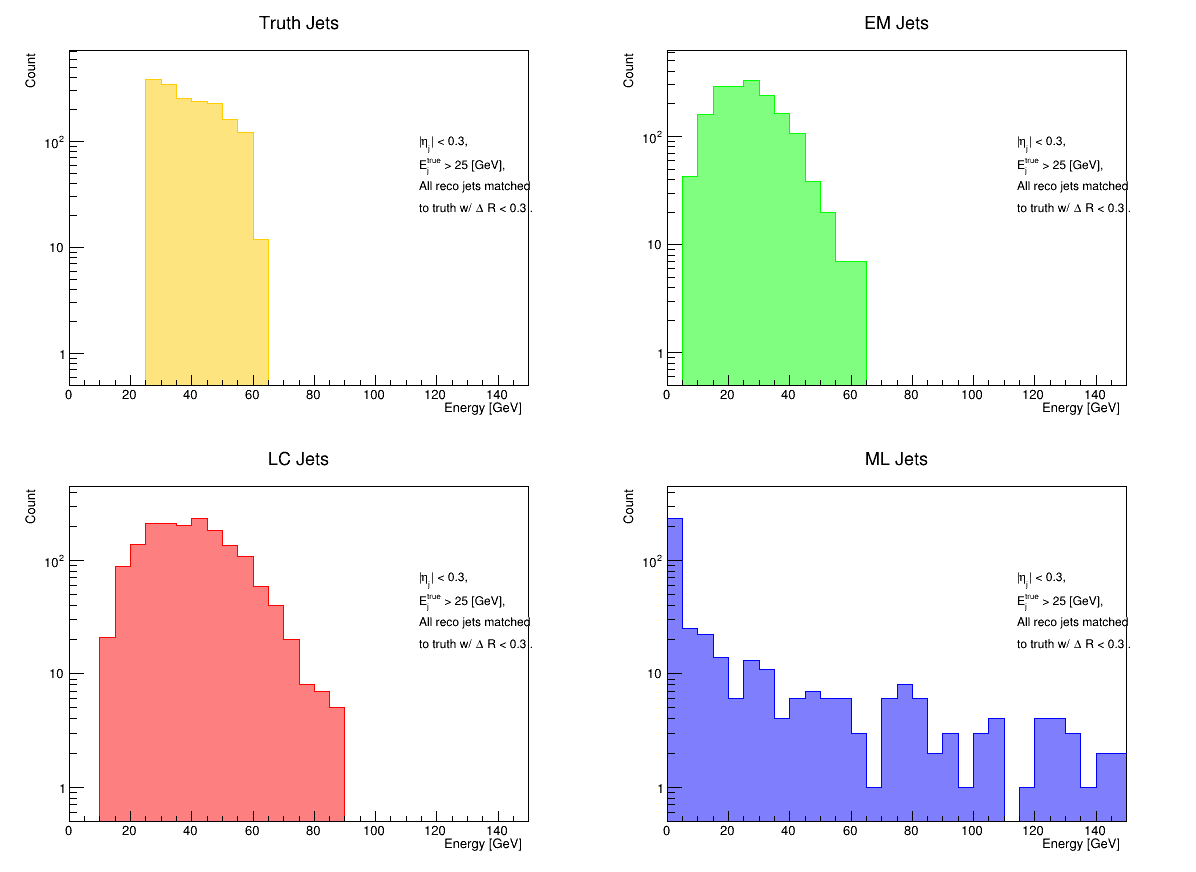

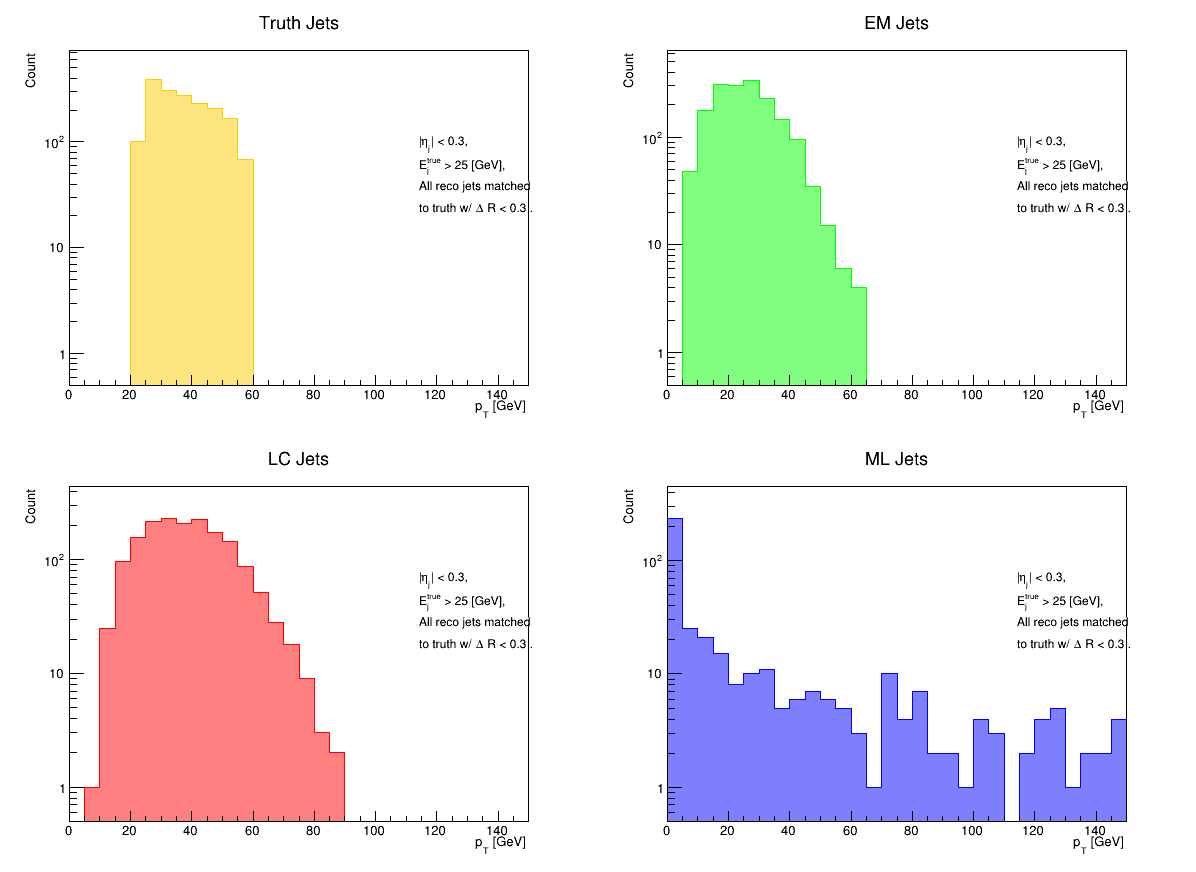

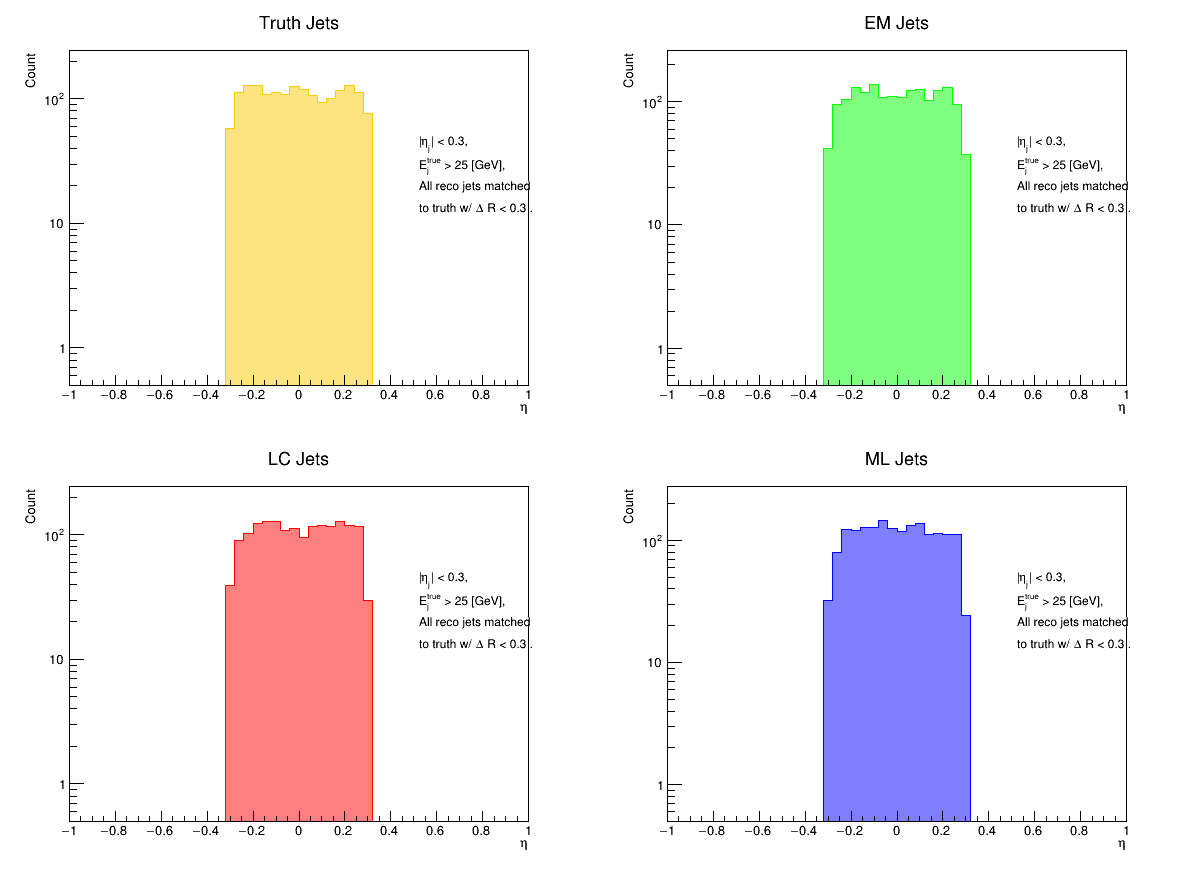

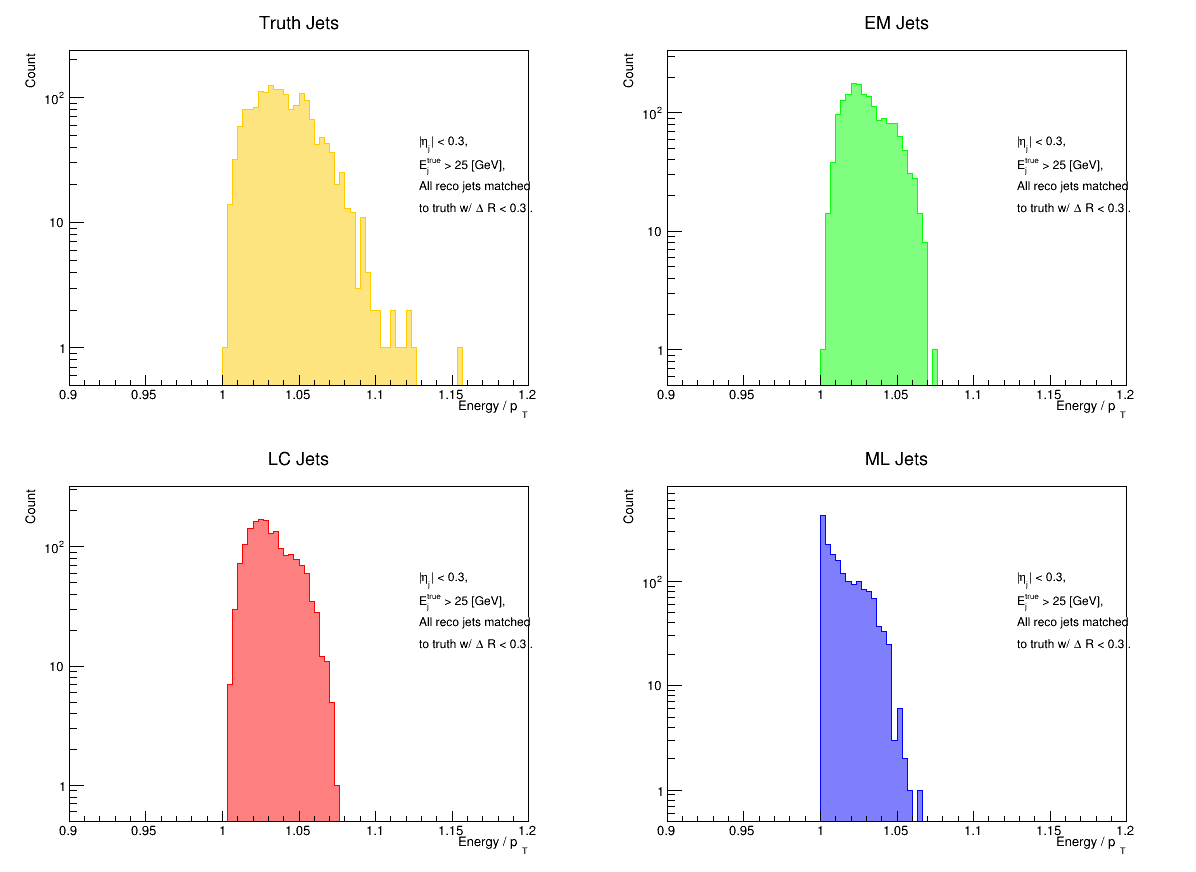

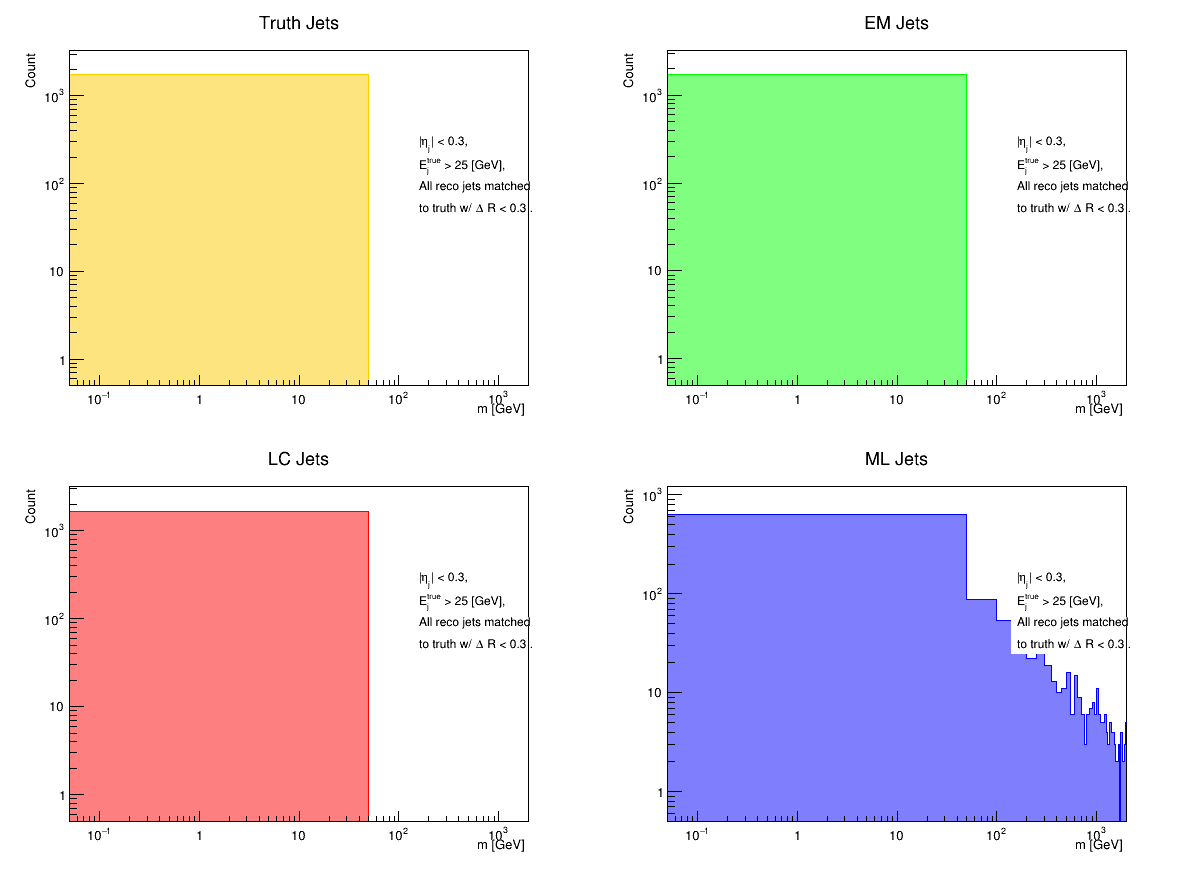

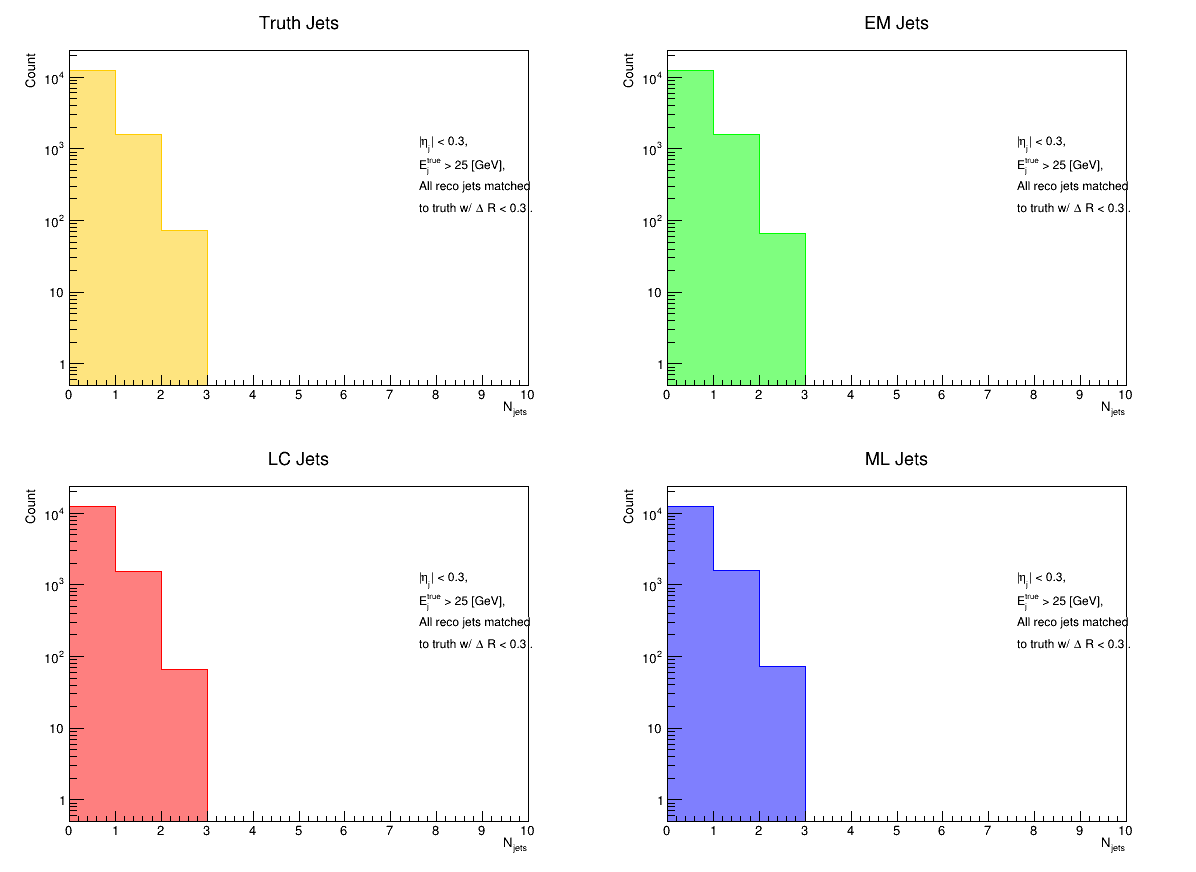

In [16]:
def DrawSet(hists, logx=False, logy=True, cut_pave = 0):
    canvas = rt.TCanvas(str(uuid.uuid4()), str(uuid.uuid4()), 1200, 900)
    nx = 2
    l = len(hists.keys())
    ny = int(np.ceil(l / nx))
    canvas.Divide(nx, ny)
    for i, hist in enumerate(hists.values()):
        canvas.cd(i+1)
        hist.Draw('HIST')
        if(logx):
            rt.gPad.SetLogx()
            hist.GetXaxis().SetRangeUser(1.0e-0, hist.GetXaxis().GetBinUpEdge(hist.GetXaxis().GetLast()))
        if(logy): 
            rt.gPad.SetLogy()
            hist.SetMinimum(5.0e-1)
        else:
            hist.SetMinimum(0.)
        if(cut_pave != 0): cut_pave.Draw()  
    return canvas

jet_defs = {
    'Truth':('event','AntiKt4TruthJets'),
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets')
}

colors = {
    'Truth': rt.kOrange,
    'EM': rt.kGreen,
    'LC': rt.kRed,
    'ML': rt.kBlue
}

scale_factors = 0.001 # jet info is in MeV, we want to plot it all in GeV

energy_hists = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy [GeV];Count', 30, 0., 150.) for key in jet_defs.keys()}
pt_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;p_{T} [GeV];Count', 30, 0., 150.) for key in jet_defs.keys()}
eta_hists    = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;#eta;Count', 50, -1., 1.) for key in jet_defs.keys()}
m_hists      = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;m [GeV];Count', 45, -250., 2000.) for key in jet_defs.keys()}
ep_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy / p_{T};Count', 90, 0.9, 1.2) for key in jet_defs.keys()}
n_hists      = {key:rt.TH1I(str(uuid.uuid4()), key + ' Jets;N_{jets};Count', 10, 0, 10) for key in jet_defs.keys()}

vec = rt.Math.PtEtaPhiEVector()
for dfile, tree in ur_trees.items():
    for key, jet_def in jet_defs.items():
        tkey  = jet_def[0]
        jname = jet_def[1]
        
        # Truth jets -- apply global jet cuts, and truth-specific jet cuts.
        if(key == 'Truth'):
            eta = tree[tkey].array(jname + 'Eta')
            energy = tree[tkey].array(jname + 'E')
            # Truth jet energy cut & jet eta cut.
            jet_indices = (np.abs(eta) <= global_eta_cut) * (energy  >= 1.0e3 * global_truth_e_cut)
        
        # Reco jets -- apply jet-matching cut (global jet cuts are built-in). No further reco-specific jet cuts for now.
        else:
            matching = tree['jet_match'].array(jname + 'Match')
            jet_indices = (matching > -1)
            
        # Now get all jets that passed the cuts.
        # First do a bit of manipulation with eta, to also get the number of jets per event.
        eta = tree[tkey].array(jname + 'Eta')[jet_indices]
        n   = [len(x) for x in eta]
        eta = eta.flatten()
        energy = scale_factors * tree[tkey].array(jname + 'E')[jet_indices].flatten()
        pt     = scale_factors * tree[tkey].array(jname + 'Pt')[jet_indices].flatten()
        ep     = energy / pt
        
        for i in range(len(n)): n_hists[key].Fill(n[i])
            
        for i in range(len(ep)):
            energy_hists[key].Fill(energy[i])
            pt_hists[key].Fill(pt[i])
            eta_hists[key].Fill(eta[i])
            ep_hists[key].Fill(ep[i])
            
            # Compute the jet mass and plot it too.
            vec.SetCoordinates(pt[i],eta[i],0.,energy[i])
            m_hists[key].Fill(vec.M())

hist_lists = [energy_hists, pt_hists, eta_hists, ep_hists, m_hists, n_hists]
for key in jet_defs.keys():
    for hist_list in hist_lists:
        SetColor(hist_list[key],colors[key])            
            
rt.gStyle.SetOptStat(0)
canvases = []

for hist_list in hist_lists:
    logx = False
    if(hist_list == m_hists): logx=True
    c = DrawSet(hist_list, logx=logx, cut_pave = cut_pave)
    canvases.append(c)
    c.Draw()

The energies for the ML jets don't look great -- as we might expect, the issues with the cluster energies (mostly being way too small, and a few being way too large) is carrying over to jet clustering.

### Verifying jet clustering

For completeness, we should make sure that the jet clustering above is working properly at all. To do this, we can try to reproduce the EM jets, which just use the `clusterE` branch for their topo-cluster energies.

##### Reproducing EM jets

This code will look a lot like our jet clustering above, but we will be using the default reco energy. We'll save our new EM jets to a tree called `JetTree_EM`.

Note that we *will* apply a $5$ GeV minimum $p_T$ cut to the jets that we produce, as we can see that this was applied to the original EM jets and we're trying to reproduce those results.

In [17]:
sys.path.append(fj_dir)
import fastjet as fj

# Jet clustering params
R = 0.4
pt_min = 5.0 # min jet pT (GeV)
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

#energy rescaling (all jet info is saved in keV, not GeV)
energy_scaling = 1.0e3

# branch buffer for our jet tree
branch_buffer = {
    'AntiKt4EMTopoJetsPt':rt.std.vector('float')(),
    'AntiKt4EMTopoJetsEta':rt.std.vector('float')(),
    'AntiKt4EMTopoJetsPhi':rt.std.vector('float')(),
    'AntiKt4EMTopoJetsE':rt.std.vector('float')()
}

for dfile, tree in ur_trees.items():
    
    # event info
    cluster_min = tree['event'].array('clusterCount')
    cluster_max = cluster_min + tree['event'].array('nCluster') - 1
    
    # cluster info (pre-existing)
    cluster_vec = np.column_stack(tuple(tree['cluster'].arrays(['clusterPt','clusterEta','clusterPhi','clusterE']).values()))
#     cluster_vec = np.column_stack(tuple(trees['cluster'].arrays(['clusterPt','clusterEta','clusterPhi','cluster_ENG_CALIB_TOT']).values()))


    # tree for saving jet info
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'JetTree_EM'
    t = rt.TTree(tree_name, tree_name)
    
    branches = {}
    for key,val in branch_buffer.items():
        branches[key] = t.Branch(key, val)
    
    vec_polar = rt.Math.PtEtaPhiEVector()    
    # loop over events
    nevents = tree['event'].numentries
    for i in range(nevents):
        cluster_idxs = np.linspace(cluster_min[i], cluster_max[i], cluster_max[i] - cluster_min[i] + 1, dtype=np.dtype('i8'))        
        nCluster = cluster_idxs.shape[0]
                
        pseudojets = []
        for j, idx in enumerate(cluster_idxs):
            vec_polar.SetCoordinates(cluster_vec[idx,0],cluster_vec[idx,1],cluster_vec[idx,2],cluster_vec[idx,3])
            pseudojets.append(fj.PseudoJet(vec_polar.Px(), vec_polar.Py(), vec_polar.Pz(), vec_polar.E())) # fastjet uses Cartesian as input
        jets = jet_def(pseudojets) # perform jet clustering
        
        # Apply optional minimum jet pT cut
        jet_pt = np.array([jet.pt() for jet in jets])
        jet_indices = np.linspace(0,len(jets)-1,len(jets),dtype=np.dtype('i8'))[jet_pt >= pt_min]
        jets = [jets[i] for i in jet_indices]
        njets = len(jets)
        
        # TODO: save jet info to a TTree
        for key in branch_buffer.keys(): branch_buffer[key].clear()
            
        for j in range(njets):    
#             vec.SetCoordinates(jets[j].pt(), jets[j].eta(), jets[j].phi(), jets[j].e())
#             print(vec.E(), vec.P(), vec.M())
#             #print(jets[j].pt(), jets[j].e())
            branch_buffer['AntiKt4EMTopoJetsPt'].push_back(jets[j].pt() * energy_scaling)
            branch_buffer['AntiKt4EMTopoJetsEta'].push_back(jets[j].eta())
            branch_buffer['AntiKt4EMTopoJetsPhi'].push_back(jets[j].phi())
            branch_buffer['AntiKt4EMTopoJetsE'].push_back(jets[j].e() * energy_scaling)
        
        t.Fill()
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()

tree_names['jet_em'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

We *also* need to match our new `EM2` jets to truth jets, for a fair comparison with the `EM` jets. We will save the matching info to `JetMatchTree_EM`.

In [18]:
   #Saving jet matching info to a new tree

R = 0.3 # radius for jet-matching

index_type = ('int',np.dtype('i4')) # allows us to choose how we store matching indices, e.g. int, short
branch_buffer = {
    'AntiKt4EMTopoJetsMatch':rt.std.vector(index_type[0])()
}
jet_definitions = {
    'EM':('jet_em', 'AntiKt4EMTopoJets'),
    'Truth':('event', 'AntiKt4TruthJets')
}
reco_jet_defs = ['EM']

for dfile, tree in ur_trees.items():   
        
    # tree for saving jet matching info
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'JetMatchTree_EM'
    t = rt.TTree(tree_name, tree_name)
    branches = {}
    for key,val in branch_buffer.items():
        branches[key] = t.Branch(key, val)
    
    # Determine which jets pass our global eta cut.
    eta = {key:tree[val[0]].array(val[1] + 'Eta') for key, val in jet_definitions.items()}
    jet_indices = {key: np.abs(x) <= global_eta_cut for key,x in eta.items()}
    
    # Apply our truth jet energy cut. Recall that jets have things stored in MeV for now, whereas the cut is in GeV.
    truth_energy = tree[jet_definitions['Truth'][0]].array(jet_definitions['Truth'][1] + 'E')
    jet_indices['Truth'] = jet_indices['Truth'] * (truth_energy >= 1.0e3 * global_truth_e_cut)
    
    # We will also need phi info for performing the matching.
    phi = {key:tree[val[0]].array(val[1] + 'Phi') for key, val in jet_definitions.items()}

    nevents = ur_trees[dfile]['event'].numentries
    for i in range(nevents):
        
        # For each event, store the jets that have passed our pre-selection cuts.
        selected_jets = {}
        
        for key in jet_indices.keys():
            selected_jets[key] = {'eta':eta[key][i][jet_indices[key][i]],'phi':phi[key][i][jet_indices[key][i]]}
            
        # TODO: Consider eliminating this conditional, see if it really speeds things up at all.
        # Speedup: Skip to next event if *no* truth jets were selected (there will be no matching to do anyway).
        # Make sure to fill our branch buffers with -1 for each reco jet, to explicitly label them as unmatched.
        # (We want the length of these vectors to *always* match the number of reco jets!)
        if(len(selected_jets['Truth']['eta']) == 0): 
            for rdef in reco_jet_defs:
                buffer_key = jet_definitions[rdef][1] + 'Match'
                branch_buffer[buffer_key].clear()
                n = len(jet_indices[rdef][i]) # total number of reco jets for this event (including those not passing cuts)
                for j in range(n): branch_buffer[buffer_key].push_back(int(-1))
            t.Fill()
            continue
            
        # Keeping track of which indices are present and dropped.
        # For each jet definition, this dictionary lists all jet indices w.r.t. the tree, that have passed cuts.
        # E.g. if EM jets at positions 0, 4 and 5 in our branch passed cuts, then jet_tree_indices['EM']=np.array([0,4,5]).
        # More user-friendly than a boolean array of full length, e.g. [True, False, False, False, True, True,...].
        # Note that jet_indices[key] is an Awkward array, so jet_indices[key][i] gives the i'th entry, for the i'th event,
        # whose length might differ from the j'th entry jet_indices[key][j] (a.k.a. a "jagged array").
        jet_tree_indices = {key:np.linspace(0,len(jet_indices[key][i])-1,len(jet_indices[key][i]),dtype=np.dtype('i2'))[jet_indices[key][i]] for key in jet_indices.keys()}        
        
        # Now perform matching for each reco jet definition.
        for rdef in reco_jet_defs:
            buffer_key = jet_definitions[rdef][1] + 'Match' # key for accessing TTree branch buffer
            branch_buffer[buffer_key].clear()

            # Info on (reco,truth) pairs, as well as any unmatched reco and truth jets.
            matches, unmatch_true, unmatch_reco = jet_matching(reco_jets=selected_jets[rdef], truth_jets=selected_jets['Truth'], max_distance=R).values()
            
            # If we don't find matches, we can skip the rest of this loop. 
            # Make sure to fill the vectors with a bunch of -1's to indicate unmatched reco jets.
            # (We want the length of these vectors to *always* match the number of reco jets!)
            if(matches == []):
                n = len(jet_indices[rdef][i])
                for j in range(n): branch_buffer[buffer_key].push_back(int(-1))
                continue
                
            # Convert from indices amongst selected jets, to indices amongst all jets in tree.
            matches = IndexConversion(np.array(matches,dtype=index_type[1]), jet_tree_indices[rdef], jet_tree_indices['Truth'])           
     
            # Now prepare to fill the branch buffer. Each position correspond to a reco jet in our tree.
            # We will fill each position with the index of the truth jet (in the tree) to which it's matched.
            # If a particular reco jet is not matched, we will label it with a -1.
        
            # We prep results in a numpy array, we'll push_back the whole thing when ready.
            match_list = np.full(len(jet_indices[rdef][i]),-1,dtype=index_type[1])
            for row in matches: match_list[row[1]] = row[0]            
            
            # Now prepare to fill the branch buffer. Each position correspond to a reco jet in our tree.
            # We will fill each position with the index of the truth jet (in the tree) to which it's matched.
            # If a particular reco jet is not matched, we will label it with a -1.
            
            # Note that the first column of matches gives truth jet indices, the second column gives reco indices.
            # We will first fill the vector with -1's, then make replacements as necessary (we can treat it like np vector).
            for entry in match_list: branch_buffer[buffer_key].push_back(int(entry)) # TODO: Why do we need to cast to Python int?
            
        # The branch buffers have been filled, time to write this event to the tree.
        t.Fill()
    
    # Done writing events. Write tree to file
    t.Write(tree_name,rt.TObject.kOverwrite)
    f.Close()
    
# update our uproot tree access dictionary, adding our new tree!
tree_names['jet_match_em'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Now let's plot the kinematic distributions of our new EM jets and the old EM jets. Our hope is that they match. Note that we might expect to find some lower $p_T$ jets too, as it looks like a $p_T$ cut was applied to the original EM jets and we aren't necessarily applying one here.

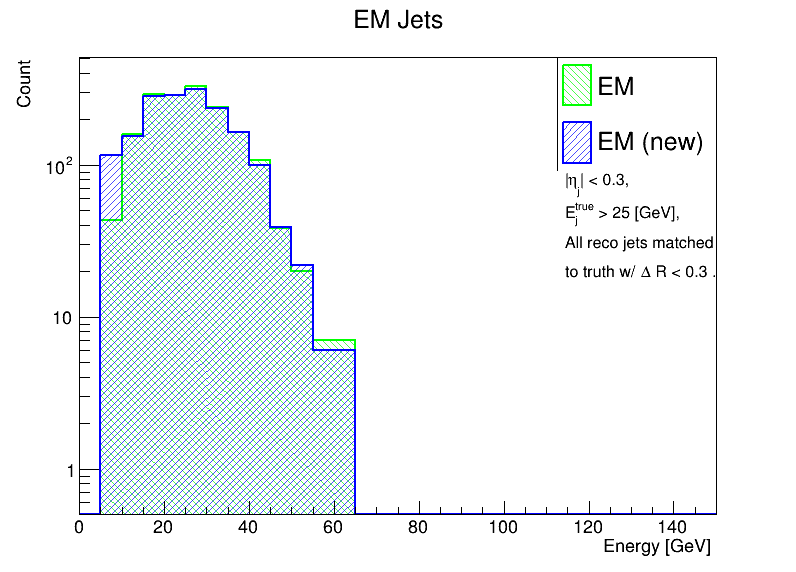

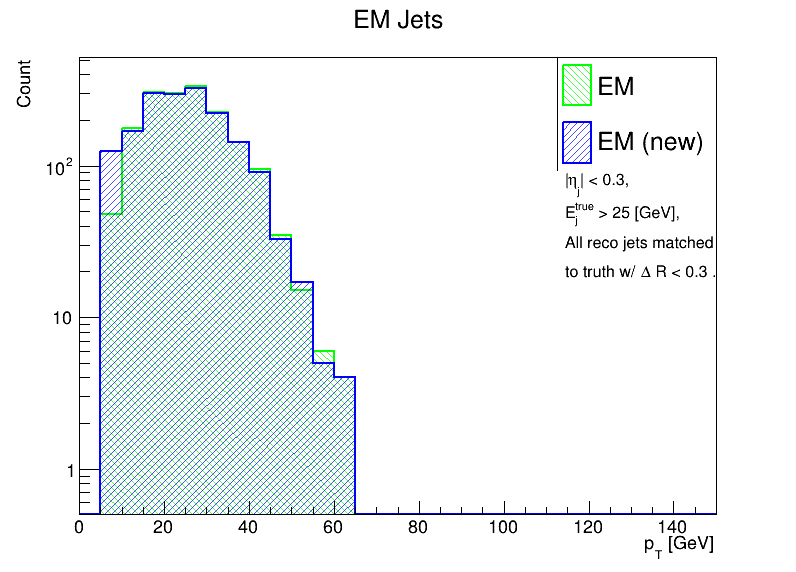

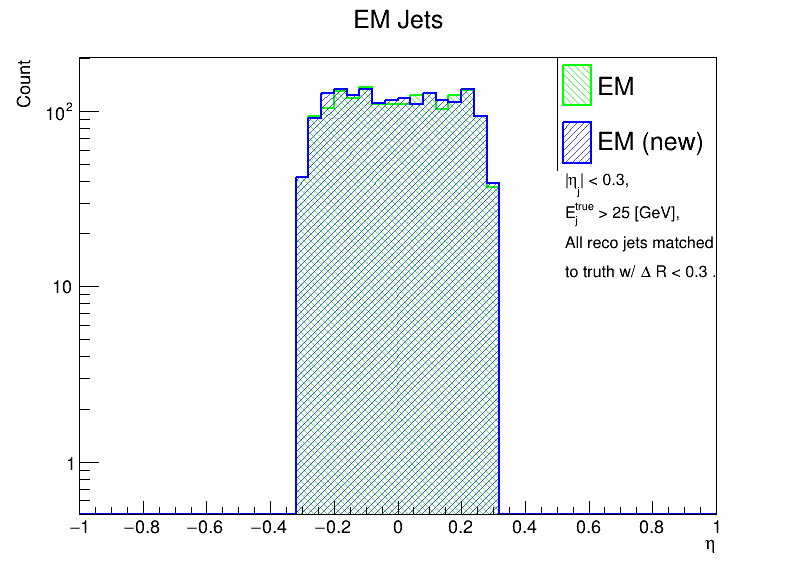

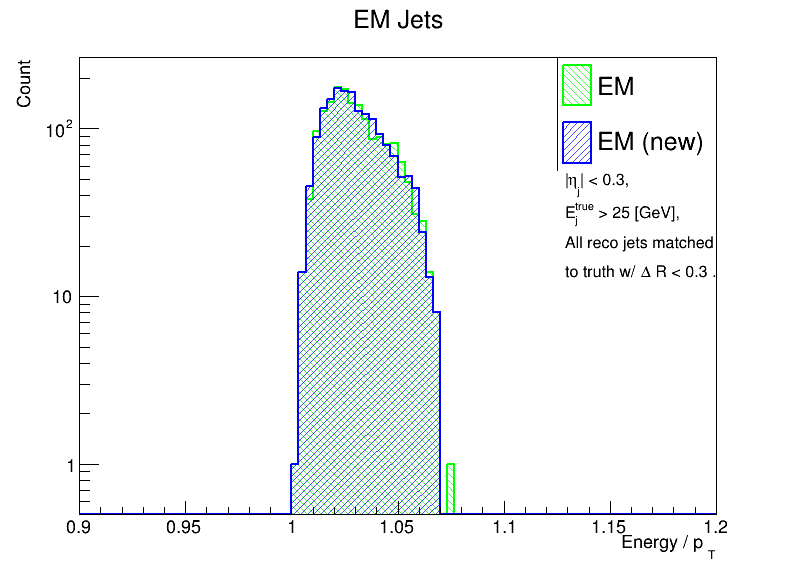

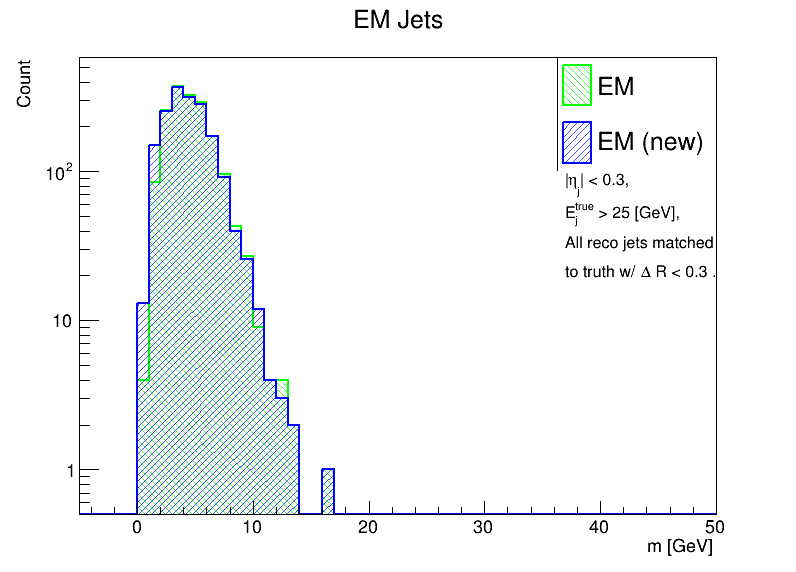

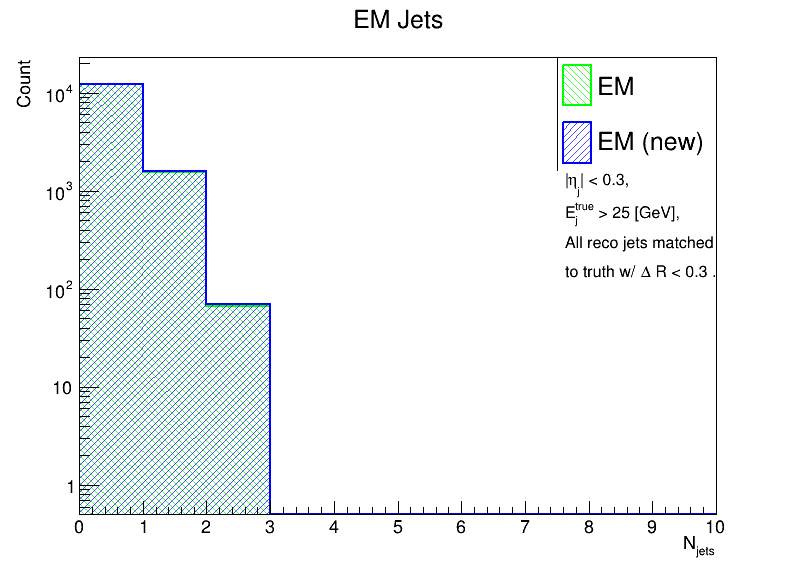

In [19]:
jet_defs = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'EM2':('jet_em', 'AntiKt4EMTopoJets'),
}

colors = {
    'EM': rt.kGreen,
    'EM2': rt.kBlue
}

scale_factors = 0.001 # jet info is in MeV, we want to plot it all in GeV
energy_hists = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy [GeV];Count', 30, 0., 150.) for key in jet_defs.keys()}
pt_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;p_{T} [GeV];Count', 30, 0., 150.) for key in jet_defs.keys()}
eta_hists    = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;#eta;Count', 50, -1., 1.) for key in jet_defs.keys()}
m_hists      = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;m [GeV];Count', 55, -5., 50.) for key in jet_defs.keys()}
ep_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy / p_{T};Count', 90, 0.9, 1.2) for key in jet_defs.keys()}
n_hists      = {key:rt.TH1I(str(uuid.uuid4()), key + ' Jets;N_{jets};Count', 10, 0, 10) for key in jet_defs.keys()}

vec = rt.Math.PtEtaPhiEVector()
for dfile, tree in ur_trees.items():
    for key, jet_def in jet_defs.items():
        tkey  = jet_def[0]
        jname = jet_def[1]
        
        # Truth jets -- apply global jet cuts, and truth-specific jet cuts.
        if(key == 'Truth'):
            eta = tree[tkey].array(jname + 'Eta')
            energy = tree[tkey].array(jname + 'E')
            # Truth jet energy cut & jet eta cut.
            jet_indices = (np.abs(eta) <= global_eta_cut) * (energy  >= 1.0e3 * global_truth_e_cut)
        
        # Reco jets -- apply jet-matching cut (global jet cuts are built-in). No further reco-specific jet cuts for now.
        else:
            jmatch_key = 'jet_match'
            if(key == 'EM2'): jmatch_key = 'jet_match_em'
            matching = tree[jmatch_key].array(jname + 'Match')
            jet_indices = (matching > -1)
            
        # Now get all jets that passed the cuts.
        # First do a bit of manipulation with eta, to also get the number of jets per event.
        eta = tree[tkey].array(jname + 'Eta')[jet_indices]
        n   = [len(x) for x in eta]
        eta = eta.flatten()
        energy = scale_factors * tree[tkey].array(jname + 'E')[jet_indices].flatten()
        pt     = scale_factors * tree[tkey].array(jname + 'Pt')[jet_indices].flatten()
        ep     = energy / pt
        
        for i in range(len(n)): n_hists[key].Fill(n[i])
            
        for i in range(len(ep)):
            energy_hists[key].Fill(energy[i])
            pt_hists[key].Fill(pt[i])
            eta_hists[key].Fill(eta[i])
            ep_hists[key].Fill(ep[i])
            
            # Compute the jet mass and plot it too.
            vec.SetCoordinates(pt[i],eta[i],0.,energy[i])
            m_hists[key].Fill(vec.M())

hist_lists = [energy_hists, pt_hists, eta_hists, ep_hists, m_hists, n_hists]

styles = { 'EM': 3245,  'EM2': 3254}# fill styles
for key in jet_defs.keys():
    for hist_list in hist_lists:
        SetColor(hist_list[key],colors[key],alpha = 0.7)
        hist_list[key].SetFillStyle(styles[key])
        hist_list[key].SetLineWidth(2)
            
legend = rt.TLegend(0.7,0.7,0.9,0.9)
legend.AddEntry(energy_hists['EM'],'EM','f')
legend.AddEntry(energy_hists['EM2'],'EM (new)','f')

rt.gStyle.SetOptStat(0)
canvases = []
stacks = []
for hist_list in hist_lists:
    c = rt.TCanvas(str(uuid.uuid4()), str(uuid.uuid4()), 800, 600)
    c.cd()
    c.SetLogy()
    stack = rt.THStack(str(uuid.uuid4()),'')
    stack.SetTitle(list(hist_list.values())[0].GetTitle())
    for key in hist_list.keys():
        stack.Add(hist_list[key])
    stack.Draw('NOSTACK HIST')
    legend.Draw()
    cut_pave.Draw()
    stack.GetXaxis().SetTitle(list(hist_list.values())[0].GetXaxis().GetTitle())
    stack.GetYaxis().SetTitle(list(hist_list.values())[0].GetYaxis().GetTitle())
    stack.SetMinimum(5.0e-1)
    canvases.append(c)
    stacks.append(stack)
    canvases[-1].Draw()

We do see some small differences in distributions. For example, the smallest non-zero bin in the energy and $p_T$ distributions. 

I'm not entirely sure how to account for this difference: We are applying our jet-matching criteria and cuts to *both* sets of jets being plotted here -- the EM jets that we were given and the ones that we re-clustered ourselves. Looking through the clustering code we have, the logic seems pretty sound to me and it looks like it almost perfectly reproduces the distributions. 
- Could edge effects be playing some small role? We don't have topo-cluster info saved for topo-clusters with $|\eta| > 0.7$. We tried to account for this by applying a jet cut of $|\eta_j| < 0.3$, but is it possible that the missing topo-clusters could still be having a small effect on our reclustering of EM jets? The only alternative I could think of is some cut being applied to the EM jets, that I haven't incorporated when re-clustering them.

## Coding "Playground" below

As an experiment, let's try rescaling the energy ratios from earlier. Is the predicted energy maybe just off by some constant factor? It seems unlikely but it doesn't hurt to try and see if rescaling the histogram will give us a (sharp?) peak near unity.

In [20]:
# mean = np.mean(jet_energy_ratios['ML'])
# print(mean)

Ok, I think the mean is thrown off by an outlier. So we can try to rescale the distribution so that the *median* or histogram *mode* is at 1.

In [21]:
# def DrawRescaledRatio(jet_energy_ratios, rescaling_factor, target_name):

#     energy_ratio_rescaled = jet_energy_ratios['ML'] * rescaling_factor
    
#     colors = {
#         'EM':rt.kGreen,
#         'LC':rt.kRed,
#         'ML':rt.kBlue
#     }
#     min_ratio = 1.0e-3
#     max_ratio = 1.0e1
#     nbins = 10000

#     hists = {key: rt.TH1F(key + 'ratio', key + ';E_{reco}/E_{true};Count',nbins,min_ratio,max_ratio) for key in ['EM','LC','ML']}
#     for key in ['EM','LC']:
#         SetColor(hists[key],colors[key])
#         for entry in jet_energy_ratios[key]:
#             hists[key].Fill(entry)

#     # our rescaled ML jet histogram
#     SetColor(hists['ML'],colors['ML'])
#     for entry in energy_ratio_rescaled:
#         hists['ML'].Fill(entry)

#     legend = rt.TLegend(0.6,0.65,0.9,0.85)
#     legend.SetBorderSize(0)

#     stack = rt.THStack('stack2','Energy Ratio;E_{reco}/E_{truth};Count')

#     for key, hist in hists.items():
#         stack.Add(hist)
#         name = key
#         if(key == 'ML'): name = target_name
#         legend.AddEntry(hist,name,'f')

#     return stack, legend

In [22]:
# median = np.median(jet_energy_ratios['ML'])
# rescaling_factor = 1. / median
# stack, legend = DrawRescaledRatio(jet_energy_ratios, rescaling_factor, target_name='ML (rescaled with median)')

# c = rt.TCanvas('c_ratio2','c_ratio2',800,600)
# rt.gStyle.SetOptStat(0)
# stack.Draw('NOSTACK HIST')
# legend.Draw()
# c.SetLogx()
# c.SetLogy()
# c.Draw()

Hmmm... rescaling the `ML` distribution to have a median of $1$ isn't quite cutting it. This suggests that there are a *lot* of events in the overflow bin.

Instead, let's try rescaling the distribution so that its peak is at $1$. Note that this is dependent on our choice of binning.

In [23]:
# nbins_tmp = 10000
# hists['ML'] = rt.TH1F(key + 'ratio', 'ML;E_{reco}/E_{true};Count',nbins_tmp,min_ratio,max_ratio)
# for entry in jet_energy_ratios['ML']:
#     hists['ML'].Fill(entry)
# binmax = hists['ML'].GetMaximumBin()
# mode = hists['ML'].GetXaxis().GetBinCenter(binmax)
# rescaling_factor = 1. / mode

# stack, legend = DrawRescaledRatio(jet_energy_ratios, rescaling_factor, target_name='ML (rescaled with mode)')
# c = rt.TCanvas('c_ratio3','c_ratio3',800,600)
# rt.gStyle.SetOptStat(0)
# stack.Draw('NOSTACK HIST')
# legend.Draw()
# c.Draw()

In [24]:
# c.SetLogx()
# c.SetLogy()
# c.Draw()

Perhaps unsurprisingly, there doesn't seem to be any obvious scaling that will improve things -- as we might expect, rescaling will stretch things out (and increase spread).